<a href="https://colab.research.google.com/github/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/01_text_classification_using_feature_extractors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Text Classification

Text classification is one of the most common tasks in NLP and can be used for applications
such as tagging customer feedback into categories or routing support tickets according to their
language. Chances are that your email’s spam filter is using text classification to protect your
inbox from a deluge of unwanted junk!

Another common type of text classification is sentiment analysis, which aims to identify the
polarity of a given text.

Now imagine that you are a data scientist who needs to build a system that can automatically
identify emotional states such as “anger” or “joy” that people express towards your company’s
product on Twitter. 

Until 2018, the deep learning approach to this problem typically involved
finding a suitable neural architecture for the task and training it from scratch on a dataset of
labeled tweets. This approach suffered from three major drawbacks:

- You needed a lot of labeled data to train accurate models like recurrent or
convolutional neural networks.
- Training these models from scratch was time consuming and expensive.
- The trained model could not be easily adapted to a new task, e.g. with a different set of labels.

Nowadays, these limitations are largely overcome via transfer learning, where typically a
Transformer-based architecture is pretrained on a generic task such as language modeling and
then reused for a wide variety of downstream tasks.

##Setup

In [ ]:
!pip -q install transformers[sentencepiece]
!pip -q install datasets

In [ ]:
!pip -q install umap-learn

In [3]:
from transformers import pipeline
from transformers import set_seed
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

from datasets import list_datasets, load_dataset

import torch
from torch.nn.functional import cross_entropy

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##The Dataset

To build our emotion detector we’ll use a great dataset from an article that explored how
emotions are represented in English Twitter messages. 

Unlike most sentiment analysis datasets
that involve just “positive” and “negative” polarities, this dataset contains six basic emotions:
anger, disgust, fear, joy, sadness, and surprise. 


Given a tweet, our task will be to train a model
that can classify it into one of these emotions!

###Overview of Datasets

In [5]:
# We can use the list_datasets function to see what datasets are available in the Hub:
datasets = list_datasets()

print(f"There are {len(datasets)} datasets currently available on the Hub.")
print(f"The first 10 are: {datasets[:10]}")

There are 3342 datasets currently available on the Hub.
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


We see that each dataset is given a name, so let’s inspect the metadata associated with the
emotion dataset:

In [6]:
metadata = list_datasets(with_details=True)[datasets.index("emotion")]

# Show dataset description
print("Description:", metadata.description, "\n")
# Show first 8 lines of the citation string
print("Citation:", "\n".join(metadata.citation.split("\n")[:8]))

Description: Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise. For more detailed information please refer to the paper. 

Citation: @inproceedings{saravia-etal-2018-carer,
    title = "{CARER}: Contextualized Affect Representations for Emotion Recognition",
    author = "Saravia, Elvis  and
      Liu, Hsien-Chi Toby  and
      Huang, Yen-Hao  and
      Wu, Junlin  and
      Chen, Yi-Shin",
    booktitle = "Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing",


This looks like the dataset we’re after, so next we can load it with the `load_dataset` function from Datasets:

In [ ]:
emotions = load_dataset("emotion")

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

we see it is similar to a Python dictionary, with each key corresponding to a different split. 

And just like any dictionary, we can access an individual split as usual

In [8]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
len(train_ds)

16000

or access a single example by its index

In [ ]:
train_ds[0]

{'label': 0, 'text': 'i didnt feel humiliated'}

Here we see that a single row is represented as a
dictionary, where the keys correspond to the column names

In [ ]:
train_ds.column_names

['text', 'label']

This reflects the fact that Datasets is
based on Apache Arrow, which defines a typed columnar format that is more memory efficient
than native Python. 

We can see what data types are being used under the hood by accessing the
features attribute of a Dataset object:

In [ ]:
train_ds.features

{'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None),
 'text': Value(dtype='string', id=None)}

We can also access several rows with a slice

In [ ]:
train_ds[:6]

{'label': [0, 0, 3, 2, 3, 0],
 'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy',
  'ive been feeling a little burdened lately wasnt sure why that was']}

or get the full column by name

In [ ]:
train_ds["text"][:6]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was']

In each case the resulting data structure depends on the type of query; although this may feel
strange at first, it’s part of the secret sauce that makes Datasets so flexible!

##Tokenization

Transformer models like BERT cannot receive raw strings as input; instead they assume the
text has been tokenized into numerical vectors. Tokenization is the step of breaking down a
string into the atomic units used in the model. 

There are several tokenization strategies one can
adopt and the optimal splitting of words in sub-units is usually learned from the corpus.

Before
looking at the tokenizer used for BERT, let’s motivate it by looking at two extreme cases:
character and word tokenizers.

###Subword Tokenization

The idea behind subword tokenization is to take the best of both worlds from character and
word tokenization. On one hand, we want to use characters since they allow the model to deal
with rare character combinations and misspellings. On the other hand, we want to keep frequent
words and word parts as unique entities.

There are several subword tokenization algorithms such as Byte-Pair-Encoding, WordPiece,
Unigram, and SentencePiece.

The main distinguishing feature of subword tokenization (as well as word
tokenization) is that it is learned from the corpus used for pretraining.


The Transformers library provides a convenient
`from_pretrained` function that can be used to load both objects, either from the Hugging Face Model Hub or from a local path.

Let’s get started by loading the tokenizer for the DistilBERT model.

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

We can examine a few attributes of the tokenizer such as the vocabulary size:

In [10]:
tokenizer.vocab_size

30522

We can also look at the special tokens used by the tokenizer, which differ from model to model.

For example, BERT uses the `[MASK]` token for the primary objective of masked language
modeling and the `[CLS]` and `[SEP]` tokens for the secondary pretraining objective of
predicting if two sentences are consecutive:

In [ ]:
tokenizer.special_tokens_map

{'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'pad_token': '[PAD]',
 'sep_token': '[SEP]',
 'unk_token': '[UNK]'}

Furthermore, the tokenizer stores the information of the corresponding model’s maximum
context sizes:

In [ ]:
tokenizer.model_max_length

512

Lets examine how the encoding and decoding of strings works in practice by first encoding a
test string:

In [ ]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Now that we have the
`input_ids`, we can convert them back into tokens by using the tokenizer’s
`convert_ids_to_tokens()` method:

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


The AutoTokenizer class has a `convert_tokens_to_string()` method for
remove the prefix etc., so let’s apply it to our tokens:

In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


###Tokenizing the Whole Dataset

To tokenize the whole corpus, we'll use the `map()` method of our `DatasetDict` object. We'll encounter this method many times throughout this book, as it provides a convenient way to apply a processing function to each element in a dataset. As we'll soon see, the `map()` method can also be used to create new rows and columns.

To get started, the first thing we need is a processing function to tokenize our examples with:

In [11]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

This function applies the tokenizer to a batch of examples; `padding=True` will pad the examples with zeros to the size of the longest one in a batch, and `truncation=True` will truncate the examples to the model's maximum context size. 

To see `tokenize()` in action, let's pass a batch of two examples from the training set:

In [12]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Here we can see the result of padding: the first element of `input_ids` is shorter than the second, so zeros have been added to that element to make them the same length. 

These zeros have a corresponding `[PAD]` token in the vocabulary, and the set of special tokens also includes the `[CLS]` and `[SEP]` tokens that we encountered earlier:

In [13]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x: x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


Also note that in addition to returning the encoded tweets as `input_ids`, the tokenizer returns a list of `attention_mask` arrays. This is because we do not want the model to get confused by the additional padding tokens: the attention mask allows the model to ignore the padded parts of the input. It provides a visual explanation of how the input IDs and attention masks are padded.

<img alt="attention-mask" caption="For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors" src="https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/images/chapter02_attention-mask.png?raw=1" id="attention-mask"/> 

Once we've defined a processing function, we can apply it across all the splits in the corpus in a single line of code:

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

By default, the `map()` method operates individually on every example in the corpus, so setting `batched=True` will encode the tweets in batches. Because we've set `batch_size=None`, our `tokenize()` function will be applied on the full dataset as a single batch. 

This ensures that the input tensors and attention masks have the same shape globally, and we can see that this operation has added new `input_ids` and `attention_mask` columns to the dataset:

In [15]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


> Note: Later, we'll see how _data collators_ can be used to dynamically pad the tensors in each batch. Padding globally will come in handy in the next section, where we extract a feature matrix from the whole corpus.

As know, models like DistilBERT are pretrained to predict masked words in a sequence of text. However, we can't use these language models directly for text classification; we need to modify them slightly. To understand what modifications are necessary, let's take a look at the architecture of an encoder-based model like DistilBERT.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/images/chapter02_encoder-classifier.png?raw=1'/>

First, the text is tokenized and represented as one-hot vectors whose dimension is the size of
the tokenizer vocabulary, usually consisting of 50k-100k unique tokens. 

Next, these token
encodings are embedded in lower dimensions and passed through the encoder block layers to
yield a hidden state for each input token. 

For the pretraining objective of language modeling,
each hidden state is connected to a layer that predicts the token for the input token, which is
only non-trivial if the input token was masked. 

For the classification task, we replace the
language modeling layer with a classification layer. BERT sequences always start with a
classification token `[CLS]`, therefore we use the hidden state for the classification token as
input for our classification layer.

We have two options to train such a model on our Twitter dataset:
- **Feature extraction**
  - We use the hidden states as features and just train a classifier on them.
- **Fine-tuning**
  - We train the whole model end-to-end, which also updates the parameters of the pretrained BERT model.

In this section we explore both options for DistilBert and examine their trade-offs.

##Transformers as Feature Extractors

To use a Transformer as a feature extractor is fairly simple;we freeze
the body’s weights during training and use the hidden states as features for the classifier. 

The advantage of this approach is that we can quickly train a small or shallow model. Such a model
could be a neural classification layer or a method that does not rely on gradients such a Random Forest. 

This method is especially convenient if GPUs are unavailable since the hidden
states can be computed relatively fast on a CPU.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/images/2.png?raw=1' width='800'/>

The feature-based method relies on the assumption that the hidden states capture all the
information necessary for the classification task. However, if some information is not required
for the pretraining task, it may not be encoded in the hidden state, even if it would be crucial
for the classification task. 

In this case the classification model has to work with suboptimal
data, and it is better to use the fine-tuning approach.

####Using Pretrained Models

We will use another convenient auto class Transformers called `AutoModel`. Similar to the `AutoTokenizer` class, `AutoModel` has a `from_pretrained()` method to load the weights of a pretrained model. 

Let's use this method to load the DistilBERT checkpoint:

In [ ]:
model = AutoModel.from_pretrained(model_name).to(device)

The `AutoModel` class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. 

Let's take a look at how we can extract these states from our corpus.

####Extracting the Last Hidden States

To warm up, let’s retrieve the last hidden states for a single string. The first thing we need to do is encode the string and convert the tokens to PyTorch tensors.

In [17]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


Now that we have the encodings as a tensor, the final step is to
place them on the same device as the model and pass the inputs as follows:

In [18]:
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


Here we’ve used the torch.no_grad() context manager to disable the
automatic calculation of the gradient. This is useful for inference since it
reduces the memory footprint of the computations.

The current model returns only one attribute, which is the last hidden state, so let’s examine its shape:

In [19]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

For classification tasks, it is common
practice to just use the hidden state associated with the `[CLS]` token as the
input feature. 

Since this token appears at the start of each sequence, we can
extract it by simply indexing into `outputs.last_hidden_state` as follows:

In [20]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

Now we know how to get the last hidden state for a single string; let’s do the
same for the whole dataset by creating a new hidden_state column that
stores all these vectors.

In [21]:
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

Since our model expects tensors as inputs, the next thing to do is convert the
`input_ids` and `attention_mask` columns to the "torch" format, as
follows:

In [22]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

We can then go ahead and extract the hidden states across all splits in one go:

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Notice that we did not set `batch_size=None` in this case, which means the
default `batch_size=1000` is used instead. 

As expected, applying the
`extract_ hid den_ states()` function has added a new `hidden_state`
column to our dataset:

In [24]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

Now that we have the hidden states associated with each tweet, the next step
is to train a classifier on them. 

To do that, we’ll need a feature matrix—let’s
take a look.

####Creating a Feature Matrix

The preprocessed dataset now contains all the information we need to train a clasifier on it. We
will use the hidden states as input features and the labels as targets. 

We can easily create the
corresponding arrays in the well known Scikit-Learn format as follows:

In [25]:
x_train = np.array(emotions_hidden["train"]["hidden_state"])
x_valid = np.array(emotions_hidden["validation"]["hidden_state"])

y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

x_train.shape, x_valid.shape

((16000, 768), (2000, 768))

Before we train a model on the hidden states, it's good practice to perform a sanity check to ensure that they provide a useful representation of the emotions we want to classify. 

In the next section, we'll see how visualizing the features provides a fast way to achieve this.

####Dimensionality Reduction with UMAP

Before we train a model on the hidden states, it is good practice to perform a sanity check that
they provide a useful representation of the emotions we want to classify. 

Since visualising the hidden states in 768 dimensions is tricky to say the least, we’ll use the powerful UMAP algorithm to project the vectors down to 2D. 

Since UMAP works best when the features are scaled to lie in the `[0,1]` interval, we’ll first apply a MinMaxScaler and then use UMAP to
reduce the hidden states:

In [26]:
# Scale features to [0,1] range
x_scaled = MinMaxScaler().fit_transform(x_train)
# Initialize and fit UMAP
mapper = umap.UMAP(n_components=2, metric="cosine").fit(x_scaled)

# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train

df_emb.head()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


,X,Y,label
0,4.263856,7.386122,0
1,-3.017067,6.642220,0
2,5.466436,3.854279,3
3,-2.305874,4.443530,2
4,-3.185508,4.700703,3


The result is an array with the same number of training samples, but with only 2 features instead of the 768 we started with! 

Let us investigate the compressed data a little bit further and
plot the density of points for each category separately:

In [27]:
labels= emotions["train"].features["label"]
labels.names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

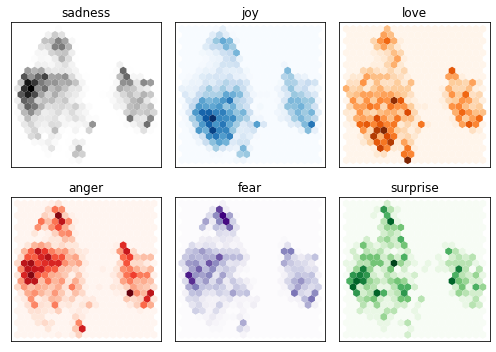

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels= emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

>These are only projections onto a lower dimensional space. Just because some categories overlap does not mean
that they are not separable in the original space. Conversely, if they are separable in the projected space they will
be separable in the original space.

Now there seem to be clearer patterns; the negative feelings such as sadness, anger and
fear all occupy a similar regions with slightly varying distributions. 

On the other hand, joy
and love are well separated from the negative emotions and also share a similar space.

Finally, surprise is scattered all over the place. We hoped for some separation but this in no
way guaranteed since the model was not trained to know the difference between this emotions
but learned them implicitly by predicting missing words.

####Training a Simple Classifier

We have seen that the hidden states are somewhat different between the emotions, although for
several of them there is not an obvious boundary. 

Let’s use these hidden states to train a simple
logistic regressor with Scikit-Learn! Training such a simple model is fast and does not require a GPU:

In [29]:
#  We increase `max_iter` to guarantee convergence 
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(x_train, y_train)

LogisticRegression(max_iter=3000)

In [30]:
lr_clf.score(x_valid, y_valid)

0.633

By looking at the accuracy it might appear that our model is just a bit better than random, but
since we are dealing with an unbalanced multiclass dataset this is significantly better than
random. We can get a better feeling for whether our model is any good by comparing against a
simple baseline.

In Scikit-Learn there is a `DummyClassifier` that can be used to build a
classifier with simple heuristics such as always choose the majority class or always draw a random class. In this case the best performing heuristic is to always choose the most frequent class:

In [31]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
dummy_clf.score(x_valid, y_valid)

0.352

So, our simple classifier with DistilBERT embeddings is significantly better than our baseline. 

We can further investigate the performance of the model by looking at the confusion matrix of the classifier, which tells us the relationship between the true and predicted labels:

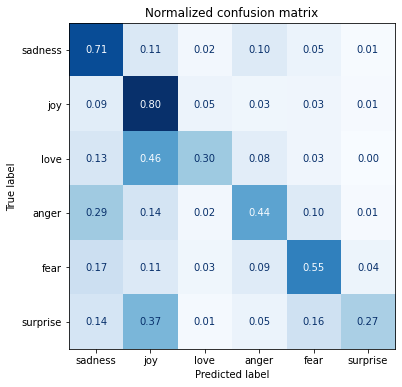

In [34]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(x_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

We can see that `anger` and `fear` are most often confused with `sadness`, which agrees with the observation we made when visualizing the embeddings. Also, `love` and `surprise` are frequently mistaken for `joy`.

In [36]:
print(classification_report(y_valid, y_preds, target_names=labels))

              precision    recall  f1-score   support

     sadness       0.65      0.71      0.68       550
         joy       0.71      0.80      0.75       704
        love       0.49      0.30      0.37       178
       anger       0.51      0.44      0.47       275
        fear       0.55      0.55      0.55       212
    surprise       0.54      0.27      0.36        81

    accuracy                           0.63      2000
   macro avg       0.57      0.51      0.53      2000
weighted avg       0.62      0.63      0.62      2000



Now, we will explore the fine-tuning approach which leads to superior
classification performance. It is however important to note, that doing this requires much more
computational resources, such as GPUs, that might not be available in your company. 

In cases
like this, a feature-based approach can be a good compromise between doing traditional
machine learning and deep learning.

##Making Predictions

We can also use the fine-tuned model to make predictions on new tweets. 

First, we need to
tokenize the text, pass the tensor through the model, and extract the logits:

In [58]:
custom_tweet = "i saw a movie today and it was really good."
input_tensor = tokenizer(custom_tweet, return_tensors="pt").to(device)
# logits = lr_clf.predict(input_tensor.cpu().numpy()).logits
# logits = model(input_tensor).logits
print(f"Input tensor shape: {input_tensor['input_ids'].size()}")

Input tensor shape: torch.Size([1, 13])


In [59]:
inputs = {k:v.to(device) for k,v in input_tensor.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[ 0.1135, -0.1893, -0.0793,  ..., -0.0236,  0.3456,  0.1747],
         [ 0.5735, -0.5289, -0.2483,  ..., -0.2529,  0.8052,  0.0033],
         [ 0.0477, -0.5381,  0.4829,  ..., -0.1972,  0.2453, -0.6509],
         ...,
         [ 0.0060, -0.2709,  0.1621,  ..., -0.1915,  0.3236, -0.7069],
         [ 0.7006, -0.0351, -0.5565,  ...,  0.3081, -0.1986, -0.5850],
         [ 0.6324, -0.0124, -0.2455,  ...,  0.2976, -0.1591, -0.4604]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [60]:
outputs.last_hidden_state.size()

torch.Size([1, 13, 768])

The model predictions are not normalized meaning that they are not a probability distribution
but the raw outputs before the softmax layer:

In [61]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [69]:
lr_clf.predict(outputs.cpu().numpy())

AttributeError: ignored

We can easily make the predictions a probability distribution by applying a softmax function to
them. 

Since we have a batch size of 1, we can get rid of the first dimension and convert the
tensor to a NumPy array for processing on the CPU:

In [42]:
softmax = torch.nn.Softmax(dim=1)
probs = softmax(input_tensor)[0]
probs = probs.cpu().detach().numpy()

RuntimeError: ignored

In [ ]:
probs

Finally, we can plot the probability for each class in a bar plot. 

Clearly, the model estimates that
the most likely class is joy, which appears to be reasonable given the tweet.

In [ ]:
labels

In [ ]:
plt.bar(labels.names, 100 * probs, color="C0")
plt.title(f"Prediction for : '{custom_tweet}'")
plt.ylabel("Class probability (%)")

##Error Analysis

A simple, yet
powerful tool is to sort the validation samples by the model loss. When passing the label during
the forward pass, the loss is automatically calculated and returned. Below is a function that
returns the loss along with the predicted label.

In [ ]:
def forward_pass_with_label(batch):
  input_ids = torch.tensor(batch["input_ids"], device=device)
  attention_mask = torch.tensor(batch["attention_mask"], device=device)
  labels = torch.tensor(batch["label"], device=device)
  print(labels)

  with torch.no_grad():
    output = model(input_ids, attention_mask)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, labels, reduction="none")

  batch["predicted_label"] = pred_label.cpu().numpy()
  batch["loss"] = loss.cpu().numpy()
  return batch

Using the `DatasetDict.map` function once more, we apply the function to get the losses for
all the samples:

In [ ]:
emotions_encoded.reset_format()
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

tensor([0, 0, 2, 3, 1, 1, 1, 1, 1, 0, 3, 1, 0, 0, 0, 1], device='cuda:0')
tensor([0, 3, 2, 1, 4, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0], device='cuda:0')
tensor([1, 0, 0, 1, 0, 0, 3, 1, 2, 0, 0, 0, 3, 0, 0, 3], device='cuda:0')
tensor([2, 0, 0, 1, 1, 0, 1, 1, 3, 0, 0, 2, 2, 1, 0, 1], device='cuda:0')
tensor([1, 0, 0, 2, 4, 0, 1, 1, 1, 4, 2, 1, 0, 3, 0, 0], device='cuda:0')
tensor([0, 3, 3, 0, 3, 2, 1, 1, 2, 3, 3, 1, 2, 3, 4, 1], device='cuda:0')
tensor([3, 3, 2, 0, 3, 2, 2, 0, 1, 3, 0, 1, 0, 0, 1, 1], device='cuda:0')
tensor([0, 0, 0, 0, 1, 0, 3, 3, 3, 1, 0, 2, 4, 4, 1, 0], device='cuda:0')
tensor([4, 0, 0, 1, 3, 0, 4, 4, 2, 1, 1, 0, 1, 0, 1, 3], device='cuda:0')
tensor([5, 2, 4, 2, 0, 2, 1, 4, 3, 1, 3, 1, 5, 3, 2, 0], device='cuda:0')
tensor([4, 3, 1, 0, 1, 5, 1, 4, 4, 0, 0, 5, 0, 1, 4, 1], device='cuda:0')
tensor([4, 0, 2, 2, 0, 3, 3, 1, 1, 3, 3, 0, 0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 4, 1, 4, 1, 3, 0, 4, 1, 0, 1, 3, 3], device='cuda:0')
tensor([1, 4, 0, 4, 1, 1, 0, 0, 0, 1, 

Finally, we create a DataFrame with the texts, losses, and the predicted/true labels.

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str, split="test")
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str, split="test"))

In [ ]:
df_test.head()

,text,label,predicted_label,loss
0,im feeling quite sad and sorry for myself but ...,sadness,sadness,0.021769
1,i feel like i am still looking at a blank canv...,sadness,sadness,0.021934
2,i feel like a faithful servant,love,love,0.428474
3,i am just feeling cranky and blue,anger,anger,0.029345
4,i can have for a treat or if i am feeling festive,joy,joy,0.022436


We can now easily sort the DataFrame by the losses in either ascending or descending order.

In [ ]:
df_test.sort_values(by=["loss"], ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,5.655755
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.384926
318,i felt ashamed of these feelings and was scare...,fear,sadness,5.326014
1963,i called myself pro life and voted for perry w...,joy,sadness,5.279847
1950,i as representative of everything thats wrong ...,surprise,sadness,4.977571
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.878881
1801,i feel that he was being overshadowed by the s...,love,sadness,4.834704
1111,im lazy my characters fall into categories of ...,joy,fear,4.702950
1509,i guess this is a memoir so it feels like that...,joy,fear,4.630934
1274,i am going to several holiday parties and i ca...,joy,sadness,4.506275


We can clearly see that the model predicted some of the labels wrong. On the other hand it
seems that there are quite a few examples with no clear class which might be either mislabelled
or require an new class altogether. 

In particular, joy seems to be mislabelled several times. With
this information we can refine the dataset which often can lead to as much or more performance
gain as having more data or larger models!

In [ ]:
df_test.sort_values(by=["loss"], ascending=True).head(10)

,text,label,predicted_label,loss
1601,i feel so ungrateful when thinking saying thes...,sadness,sadness,0.016944
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.017046
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.017291
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.017595
1531,i forgive stanley hes not so quick to forgive ...,sadness,sadness,0.017609
1310,i feel like an ungrateful asshole,sadness,sadness,0.017713
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.017856
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.018021
866,i feel quite jaded and unenthusiastic about li...,sadness,sadness,0.018029
76,i feel like im an unwelcome presence whenever ...,sadness,sadness,0.018094


We now know that the joy is sometimes mislabelled and that the model is most confident about
giving the label sadness. With this information we can make targeted improvements to our dataset and also keep an eye on the class the model seems to be very confident about.

In [ ]:
df_test.sort_values(by=["label"], ascending=True).head(10)

,text,label,predicted_label,loss
1447,i feeling so agitated right now,anger,anger,0.688883
1290,ive spent the last several days feeling irrita...,anger,anger,0.029656
1289,im feeling very distracted today,anger,anger,0.053064
1287,i feel resentful in that i sacrificed alot for...,anger,anger,0.030770
1284,i look in my wallet and i feel a cold chill,anger,anger,0.051482
1279,i am feeling so violent i just fucking shudder...,anger,anger,0.035331
234,im feeling less grumpy after that,anger,anger,0.031395
1277,i will just say that i feel jealous and angry,anger,anger,0.038462
1683,i had applied for a job and they had assured m...,anger,joy,3.749578
1275,i wake up every morning excited about breakfas...,anger,anger,0.037265


In [ ]:
# selecting the true and pred mismatch labels
true_pred_labels_mismatch = df_test[df_test["label"] != df_test["predicted_label"]]

In [ ]:
true_pred_labels_mismatch

,text,label,predicted_label,loss
17,i know what it feels like he stressed glaring ...,anger,sadness,1.198635
27,i feel as if i am the beloved preparing hersel...,joy,love,1.772280
35,i am feeling very blessed today that they shar...,joy,love,1.236907
55,i didn t feel accepted,joy,love,0.806654
72,i feel that this is important in itself the fa...,joy,sadness,1.316638
...,...,...,...,...
1963,i called myself pro life and voted for perry w...,joy,sadness,5.279847
1964,i feel vaguely cheated and a little amused,joy,anger,3.938705
1987,i feel im supposed to hate dams amp all the co...,joy,anger,1.259942
1993,i feel so tortured by it,anger,fear,0.855164


In [ ]:
true_pred_labels_mismatch.shape

(150, 4)

In [ ]:
len(true_pred_labels_mismatch)

150

So, we have 150 samples that are misclassified.

In [ ]:
# selecting the true and pred mismatch labels
true_pred_labels_mismatch = df_test.loc[df_test["label"] != df_test["predicted_label"]]
true_pred_labels_mismatch

,text,label,predicted_label,loss
17,i know what it feels like he stressed glaring ...,anger,sadness,1.198635
27,i feel as if i am the beloved preparing hersel...,joy,love,1.772280
35,i am feeling very blessed today that they shar...,joy,love,1.236907
55,i didn t feel accepted,joy,love,0.806654
72,i feel that this is important in itself the fa...,joy,sadness,1.316638
...,...,...,...,...
1963,i called myself pro life and voted for perry w...,joy,sadness,5.279847
1964,i feel vaguely cheated and a little amused,joy,anger,3.938705
1987,i feel im supposed to hate dams amp all the co...,joy,anger,1.259942
1993,i feel so tortured by it,anger,fear,0.855164


##Saving the Model

Finally, we want to save the model so we can reuse it in another session or later if we want to
put it in production. 

We can save the model together with the right tokenizer in the same folder:

In [ ]:
trainer.save_model("models/distilbert-emotion")

Saving model checkpoint to models/distilbert-emotion
Configuration saved in models/distilbert-emotion/config.json
Model weights saved in models/distilbert-emotion/pytorch_model.bin


In [ ]:
tokenizer.save_pretrained("models/distilbert-emotion")

tokenizer config file saved in models/distilbert-emotion/tokenizer_config.json
Special tokens file saved in models/distilbert-emotion/special_tokens_map.json


('models/distilbert-emotion/tokenizer_config.json',
 'models/distilbert-emotion/special_tokens_map.json',
 'models/distilbert-emotion/vocab.txt',
 'models/distilbert-emotion/added_tokens.json',
 'models/distilbert-emotion/tokenizer.json')

The NLP community benefits greatly from sharing pretrained and fine-tuned models, and
everybody can share their models with others via the Hugging Face Model Hub.